In [1]:
import time
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import scipy.stats
import tracemalloc
import umap
import hdbscan
import logging
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
logging.captureWarnings(True)
# for Linux only, load font file
# mpl.font_manager.fontManager.addfont("./arial.ttf")

# configure matplotlib
# mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
np.random.seed(42)

In [2]:
def show_logos_cols(prefix, names=None, cols=3, figsize=(8,8), auto_size=True):
    file_list = []
    for img in os.listdir(prefix):
        if img.endswith(".png") == False:
            continue
        if names is not None and fn not in names:
            continue
        file_list.append(img)
    
    file_list_format = []
    for i in file_list:
        try:
            id = int(i.replace("cluster_", "").replace(".png", ""))
        except ValueError:
            id = i.replace("cluster_", "").replace(".png", "")
        file_list_format.append((i, id))
    file_list_format = sorted(file_list_format, key=lambda x:x[1]) 
    
    if len(file_list_format) % cols == 0:
        rows = len(file_list_format) // cols
    else:
        rows = len(file_list_format) // cols + 1
    if auto_size == False:
        figsize = figsize
    else:
        width = 4 * cols
        height = 1.5 * rows
        figsize = (width, height)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if len(file_list_format) > 1:
        for ax, image in zip(*[axes.reshape(-1), file_list_format]):
            fn, id = image
            img = plt.imread(prefix+"/"+fn)
            _ = ax.imshow(img)
            ax.set_title("{}".format(id))
        for ax in axes.reshape(-1):
            ax.axis("off")
    else:
        image = file_list_format[0]
        fn, id = image
        img = plt.imread(prefix+"/"+fn)
        _ = axes.imshow(img)
        axes.set_title("{}".format(id))
        axes.axis("off")
    plt.tight_layout()

In [3]:
def simulation(fn):
    # intotal 21 nt
    data = {"TF":{}, "motif_F10": {}}
    df_TF = pd.read_csv(fn, index_col=None, header=0)
    TFs = set(df_TF["TF"].tolist())
    num_of_motifs = [50, 25, 10, 10, 5]
    basespace = df_TF.columns[0:4]
    N = 0
    for TF, sim_num in zip(*[TFs, num_of_motifs]):
        motif_matrix = df_TF[df_TF["TF"] == TF]
        right_max = 21 - motif_matrix.shape[0]
        # pos = 5
        pos = np.random.randint(0, right_max)
        all_bases = []
        for idx, row in motif_matrix.iterrows():
            all_bases.append(np.random.choice(basespace, sim_num, p=row[basespace]/row[basespace].sum()))
        for i in zip(*all_bases):
            core = "".join(i)

            left = "".join(np.random.choice(basespace, pos)).lower()
            right = "".join(np.random.choice(basespace, 21 - pos - len(core))).lower()
            sim_seq = left + core + right
            data["TF"][N] = TF
            data["motif_F10"][N] = sim_seq.upper()
            N += 1
    # noise 
    for i in range(100):
        data["TF"][N] = "random_noise"
        data["motif_F10"][N] = "".join(np.random.choice(basespace, 21))
        N += 1
    return pd.DataFrame(data)
    

In [4]:
df = simulation("TFs_v2.csv")

In [5]:
df

,TF,motif_F10
0,CEBPB,CTACTATGTTTCACAACCCGA
1,CEBPB,ATGGGGCATTTCACAACAACC
2,CEBPB,GGGCTTTATTGCATAATCCCC
3,CEBPB,CCGGGGTGTTGCATAATCTAC
4,CEBPB,ATGTCGGATTGCATAACCGAA
...,...,...
195,random_noise,CTGGCCCTCGGATAGAGACAC
196,random_noise,CTCCAGTCTACATATATGAAG
197,random_noise,GAGCTTTCGGAGACTTTGAAC
198,random_noise,GCAATGATGCGGAAGAAATTG


In [6]:
df.groupby("TF").count()

,motif_F10
TF,
CEBPB,50
ESR2,10
NFKB1,10
Pdx1,5
SOX6,25
random_noise,100


In [7]:
enc = OneHotEncoder(dtype=np.int8)
enc.fit([[i] for i in "ATCG"])

def onehot_enc(row):
    seq = [[i] for i in row["motif_F10"].upper()]
    return enc.transform(seq).toarray().reshape(-1)

In [8]:
onehot_input = []
for idx, row in df.iterrows():
    onehot_input.append(onehot_enc(row))
onehot_input = np.array(onehot_input)

In [9]:
def draw_one_sample(ax, df, title=None, cluster_col="Cluster", s=3, alpha=1.0):
    clusters = list([i for i in range(1, int(df[cluster_col].max())+1)]) + [-1]
    
    for i in clusters:
        subdf = df[df[cluster_col]==i]
        if i == -1:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13

    xmin, xmax = ax.get_xlim()
    xmin = xmin -1 
    xmax = xmax + 1
    ymin, ymax = ax.get_ylim()
    ymin = ymin - 1
    ymax = ymax + 1
    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    return xmin, xmax, ymin, ymax

In [44]:
def draw_one_sample2(ax, df, title=None, cluster_col="Cluster", s=3, alpha=1.0):
    clusters = df["TF"].unique().tolist()
    
    for i in clusters:
        subdf = df[df[cluster_col]==i]
        if i == "random_noise":
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, c="lightgray", lw=None, label=i)
        else:
            ax.scatter(subdf["X"], subdf["Y"], s=s, alpha=alpha, lw=None, label=i)
            c_X = subdf["X"].mean()
            c_Y = subdf["Y"].mean()
            ax.annotate("{}".format(i), xy=(c_X, c_Y), color="k", ha="center", va="center", size=9) # , size=13

    xmin, xmax = ax.get_xlim()
    xmin = xmin -1 
    xmax = xmax + 1
    ymin, ymax = ax.get_ylim()
    ymin = ymin - 1
    ymax = ymax + 1
    # draw density
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([df["X"], df["Y"]])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    c = ax.contour(xx, yy, f, linewidths=0.5, colors="k")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_title(title)
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    return xmin, xmax, ymin, ymax

In [10]:
def UMAP(onehot_input, df, min_dist=0.01, n_neighbors=20, verbose=False, densmap=False, metric='euclidean'):
    df = df.copy()
    # this should takes ~20 sec   
    print("UMAP")
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    
    model = umap.UMAP(init="random", random_state=42, n_components=2, min_dist=min_dist, n_neighbors=n_neighbors, verbose=verbose, densmap=densmap, metric=metric)
    umap_output = model.fit_transform(onehot_input)
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    
    mem = (peak - current)/1024./1024.
    
    print("UMAP time: {} sec".format(time1))
    print("UMAP RAM: {} MB".format(mem))
    print("==================================================")
    print()
    df["X"] = umap_output[:, 0]
    df["Y"] = umap_output[:, 1]
    
    del model
    return time1, mem, df

In [11]:
def cluster_HDBSCAN(df, min_cluster_size=100, min_samples=10, cluster_selection_epsilon=0.0, cluster_selection_method='eom', draw_condensed_tree=True, soft_clustering=True, optimize=True):
    # use multi-code here
    df = df.copy()
    X = np.stack([df["X"], df["Y"]], axis=1)
    current, _ = tracemalloc.get_traced_memory()
    time0 = time.time()
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon, cluster_selection_method=cluster_selection_method, core_dist_n_jobs=4, prediction_data=True)
    if optimize == True:
        validity_scorer = make_scorer(hdbscan.validity.validity_index,greater_is_better=True)
        param_dist = {'min_samples': [10, 50,100, 200], # 1,
                      'min_cluster_size':[100,200, 300, 500, 1000],  
                      'cluster_selection_method' : ['eom'],
                     }
        n_iter_search = 20
        '''
        random_search = RandomizedSearchCV(model
                                           ,param_distributions=param_dist
                                           ,n_iter=n_iter_search
                                           ,scoring=validity_scorer 
                                           ,random_state=42)
        '''
        grid_search = GridSearchCV(model,param_dist,scoring=validity_scorer)
        # random_search.fit(X)
        grid_search.fit(X)
        # print(random_search.best_params_)
        model = grid_search.best_estimator_
        print(grid_search.best_estimator_)
        # model = random_search.best_estimator_
    yhat = model.fit(X)
    
    if soft_clustering == True:
        soft_clusters = hdbscan.all_points_membership_vectors(yhat)
        labels = [np.argmax(x) for x in soft_clusters] 
    else:
        labels = yhat.labels_
    
    time1 = time.time() - time0
    _, peak = tracemalloc.get_traced_memory()
    mem = (peak - current)/1024./1024.
    
    df["Cluster"] = [i+1 if i > -1 else -1 for i in labels ]  # re-number lables to make it human-readable
    
    print("HDBSCAN soft clustering time: {} sec".format(time1))
    print("HDBSCAN soft clustering RAM: {} Mb".format(mem))
    print("HDBSCAN cluster number: {}".format(df["Cluster"].max()))
    print("==================================================")
    # check cluster number
    print(df.groupby("Cluster")["Cluster"].count())
    
    
    if draw_condensed_tree == True:
        fig, ax = plt.subplots()
        model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
    return time1, mem, df, model


In [12]:
def extract_fasta_and_draw_motifs(prefix, df, cluster_col="Cluster", filter=None, motif_column="motif_F10", draw_logos=True):
    print("===============  {} ===============".format(prefix))
    if os.path.isdir("{}".format(prefix)) == False:
        os.mkdir("./{}".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    else:
        os.system("rm -r ./{}/*".format(prefix))
        os.mkdir("./{}/fasta".format(prefix))
        os.mkdir("./{}/logos_bits".format(prefix))
        os.mkdir("./{}/logos_bits_no_axis".format(prefix))
        os.mkdir("./{}/logos_freq".format(prefix))
        os.mkdir("./{}/logos_freq_png".format(prefix))
        os.mkdir("./{}/logos_bits_png".format(prefix))
    if filter is not None:
        df = df[df[filter] == True].copy()
    clusters = set(df[cluster_col].tolist())
    for g in clusters:
        subdf = df[df[cluster_col] == g]
        with open("./{}/fasta/cluster_{}.fa".format(prefix, g), "w") as output:
            N = 0
            for idx, row in subdf.iterrows():
                output.write(">{}\n{}\n".format(idx, row[motif_column]))  # to RNA bases .replace("T", "U")
                N += 1
            print("Cluster #{}: {}".format(g, N))
    if draw_logos == True:
        for g in clusters:
            os.system("weblogo -A dna -D fasta -F pdf --resolution 1000 --color-scheme classic --composition none -i 0 -P \"\" -f ./{prefix}/fasta/cluster_{g}.fa -o ./{prefix}/logos_bits/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A dna -D fasta -F png --resolution 1000 --color-scheme classic --composition none -i 0 -P \"\" -f ./{prefix}/fasta/cluster_{g}.fa -o ./{prefix}/logos_bits_png/cluster_{g}.png".format(prefix=prefix, g=g))

            os.system("weblogo -A dna -D fasta -F pdf -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i 0 -P \"\" -f ./{prefix}/fasta/cluster_{g}.fa -o ./{prefix}/logos_freq/cluster_{g}.pdf".format(prefix=prefix, g=g))
            
            os.system("weblogo -A dna -D fasta -F png -y Frequency --resolution 1000 --color-scheme classic --units probability --composition none -i 0 -P \"\" -f ./{prefix}/fasta/cluster_{g}.fa -o ./{prefix}/logos_freq_png/cluster_{g}.png".format(prefix=prefix, g=g)) 
            
            os.system("weblogo -A dna -D fasta -X no -Y no -P \"\" -F pdf --resolution 1000 --color-scheme classic --composition none -i 0 -f ./{prefix}/fasta/cluster_{g}.fa -o ./{prefix}/logos_bits_no_axis/cluster_{g}.pdf".format(prefix=prefix, g=g))

In [13]:
_, _, df_UMAP = UMAP(onehot_input, df, min_dist=0.01, n_neighbors=20, verbose=False, densmap=False, metric='euclidean')

UMAP
UMAP time: 4.086360454559326 sec
UMAP RAM: 0.0 MB



In [14]:
df_UMAP.to_csv("Sim_UMAP.csv")

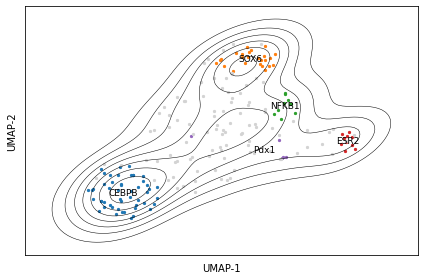

In [46]:
fig, ax = plt.subplots()
draw_one_sample2(ax, df_HDBSCAN, title=None, cluster_col="TF", s=5)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig("ground_truth.pdf")

HDBSCAN soft clustering time: 0.004876613616943359 sec
HDBSCAN soft clustering RAM: 0.0 Mb
HDBSCAN cluster number: 6
Cluster
-1    57
 1    16
 2    59
 3    11
 4    12
 5    15
 6    30
Name: Cluster, dtype: int64


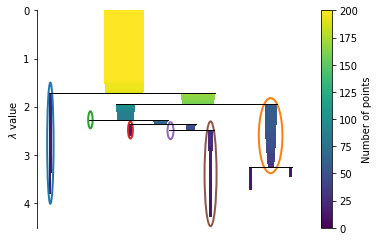

In [38]:
# _, _, df_HDBSCAN, _ = cluster_HDBSCAN(df_UMAP, min_cluster_size=100, min_samples=10, soft_clustering=False, optimize=True)
_, _, df_HDBSCAN, _ = cluster_HDBSCAN(df_UMAP, min_cluster_size=10, min_samples=5, soft_clustering=False, optimize=False)

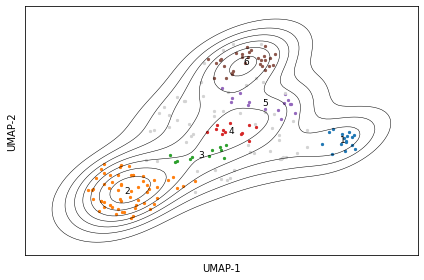

In [45]:
fig, ax = plt.subplots()
draw_one_sample(ax, df_HDBSCAN, title=None, cluster_col="Cluster", s=5)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig("iMVP_out.pdf", dpi=300)

In [40]:
with open("sim_out.fa", "w") as output:
    for idx, row in df.iterrows():
        output.write(">{}_{}\n{}\n".format(row["TF"], idx, row["motif_F10"]))

In [41]:
extract_fasta_and_draw_motifs("iMVP_out", df_HDBSCAN)

===============  iMVP_out ===============
Cluster #1: 16
Cluster #2: 59
Cluster #3: 11
Cluster #4: 12
Cluster #5: 15
Cluster #6: 30
Cluster #-1: 57


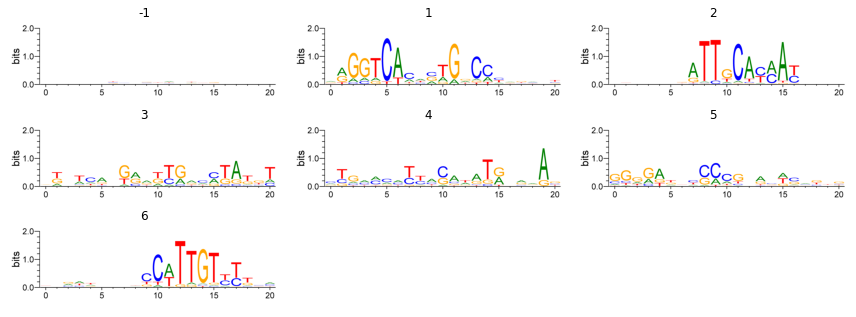

In [42]:
show_logos_cols("./iMVP_out/logos_bits_png/")

In [21]:
extract_fasta_and_draw_motifs("iMVP_out_ground_truth", df_HDBSCAN, cluster_col="TF")

===============  iMVP_out_ground_truth ===============
Cluster #CEBPB: 50
Cluster #SOX6: 25
Cluster #random_noise: 100
Cluster #NFKB1: 10
Cluster #ESR2: 10
Cluster #Pdx1: 5


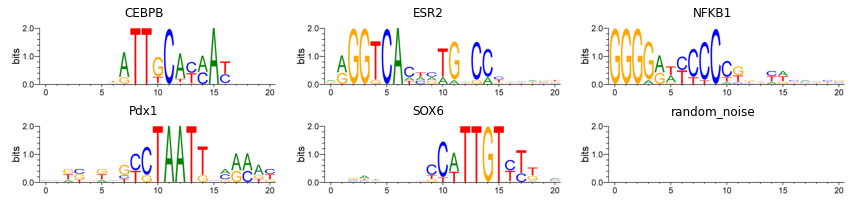

In [47]:
show_logos_cols("./iMVP_out_ground_truth/logos_bits_png/")
plt.savefig("ground_truth.jpg", dpi=300)

In [23]:
!rm temp.mat

In [24]:
from weblogo import *

def cal_bits_from_fasta(df, ID, ID_label="Cluster", motif_label="motif_F10", write_output=None):
    subdf = df[df[ID_label]==ID]
    count_data = {}
    for _, row in subdf.iterrows():
        for idx, base in enumerate(list(row[motif_label])):
            if idx not in count_data:
                count_data[idx] = {"A":0, "C":0, "G": 0, "T": 0}
            count_data[idx][base] += 1
    seqs = []
    
    count_df = pd.DataFrame.from_dict(count_data).T
    seqs = count_df.values

    # fin = open(fn)
    #  seqs = read_seq_data(fin)
    seqs = np.array(seqs)
    logodata = LogoData.from_counts(counts=seqs, alphabet='ACGT')

    temp = []
    for i in range(logodata.counts.shape[0]):
        temp.extend(list(logodata.entropy[i]*logodata.counts[i]/logodata.counts[i].sum()))
        if write_output is not None:
            write_output.write("{}\t{}\t{}\t{}\n".format(logodata.counts[i][0], logodata.counts[i][1], logodata.counts[i][2], logodata.counts[i][3]))
    write_output.write("\n")
    # reorder
    temp2 = temp[::4] + temp[1::4] + temp[2::4] + temp[3::4]
    return np.array(temp2)

with open("temp.mat", "a") as count_mat_file:
    temp = []
    for i in [1,2,3,4,5,6]:
        temp.append(cal_bits_from_fasta(df_HDBSCAN, i, write_output=count_mat_file))

In [48]:
!matrix2meme -dna < temp.mat > temp.meme

In [49]:
!sea -p sim_out.fa -m temp.meme

# Checking alphabets in 1 motif files.
# Loading motifs from file 'temp.meme'
# Alphabet: DNA
# Positive sequences "sim_out.fa" - training: 180 hold-out: 20
# Negative sequences are shuffled primary sequences (2-order) - training: 180 hold-out: 20
# Estimating background model from control sequences.
# Background: A 0.263 C 0.237 G 0.237 T 0.263
# Background order: 2 Background size: 84
# Using Fisher Exact test for p-values.
# Computing q-values.
#   Cannot estimate pi_0 accurately from fewer than 100 p-values.
#   Total p-values = 6. Using pi_zero = 1.0.
# Freeing storage...
